In [1]:
import pandas as pd
df=pd.read_csv("/content/fake reviews dataset (4).csv")

In [2]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt

In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

In [4]:
import nltk
nltk.download('punkt', download_dir='/Users/jainivedhitha/nltk_data')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jainivedhitha/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
print(nltk.data.path)

['/root/nltk_data', '/usr/nltk_data', '/usr/share/nltk_data', '/usr/lib/nltk_data', '/usr/share/nltk_data', '/usr/local/share/nltk_data', '/usr/lib/nltk_data', '/usr/local/lib/nltk_data']


In [6]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [7]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

In [8]:
def preprocess_text(text):
  tokens = nltk.word_tokenize(text)
  tokens = [word for word in tokens if word.isalpha()]  # Remove non-alphabetic tokens
  tokens = [word.lower() for word in tokens if word not in stop_words]  # Remove stopwords
  tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatization
  tokens = [stemmer.stem(word) for word in tokens]  # Stemming
  return ' '.join(tokens)

In [9]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [10]:
df['cleaned_text'] = df['text_'].apply(preprocess_text)

In [11]:
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X = tfidf.fit_transform(df['text_']).toarray()

In [12]:
X_normalized = normalize(X)

#ELBOW METHOD TO FIND THE OPTIMAL CLUSTERS

In [17]:
inertia = []
k_range = range(1, 15)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_normalized)
    inertia.append(kmeans.inertia_)

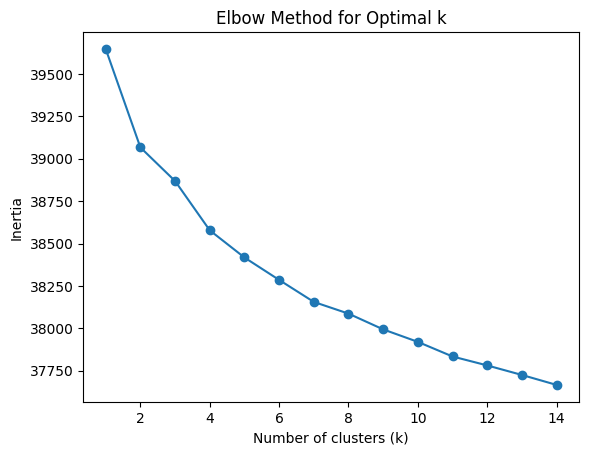

In [18]:
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

In [19]:
optimal_k = 4
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_final.fit(X_normalized)
df['cluster'] = kmeans_final.labels_

In [20]:
silhouette_avg = silhouette_score(X_normalized, df['cluster'])
print(f"Silhouette Score for K-Means: {silhouette_avg}")

Silhouette Score for K-Means: 0.009637291078291413


#DBSCAN CLUSTERING

In [21]:
from sklearn.cluster import DBSCAN

In [22]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

In [23]:
nearest_neighbors = NearestNeighbors(n_neighbors=3).fit(X_normalized)
distances, indices = nearest_neighbors.kneighbors(X_normalized)
distances = np.sort(distances[:, -1])

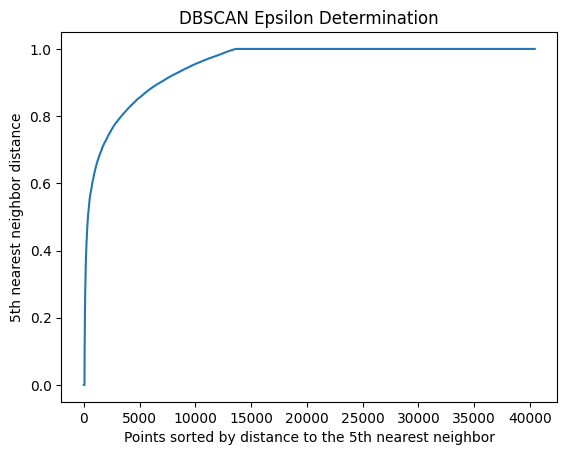

In [24]:
plt.plot(distances)
plt.xlabel("Points sorted by distance to the 5th nearest neighbor")
plt.ylabel("5th nearest neighbor distance")
plt.title("DBSCAN Epsilon Determination")
plt.show()

In [25]:
epsilon = 0.6  # Update based on the k-distance graph
min_samples = 5

In [26]:
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(X_normalized)
df['cluster'] = dbscan_labels

In [27]:
filtered_df = df[df['cluster'] != -1]
filtered_X = X[dbscan_labels != -1]
filtered_labels = dbscan_labels[dbscan_labels != -1]

In [28]:
if len(set(filtered_labels)) > 1:
    silhouette_avg = silhouette_score(filtered_X, filtered_labels)
    print(f"Silhouette Score for DBSCAN: {silhouette_avg}")
else:
    print("Silhouette Score cannot be computed as there is only one cluster or all points are noise.")

Silhouette Score for DBSCAN: 0.3739507987807208


In [29]:
lda_model = LatentDirichletAllocation(n_components=len(set(filtered_labels)), random_state=42)
lda_model.fit(filtered_X)

LatentDirichletAllocation(n_components=48, random_state=42)

In [30]:
print("\nTopics from LDA on DBSCAN Clusters:")
for idx, topic in enumerate(lda_model.components_):
    print(f"Topic {idx}: ", [tfidf.get_feature_names_out()[i] for i in topic.argsort()[-10:]])


Topics from LDA on DBSCAN Clusters:
Topic 0:  ['received', 'watch', 'im', 'higher', 'unbiased', 'purposes', 'channel', 'promised', 'youtube', 'thorough']
Topic 1:  ['friend', 'used', 'dog', 'able', 'fixed', 'plug', 'remove', 'sensitive', 'ear', 'ears']
Topic 2:  ['felt', 'fell', 'feet', 'feels', 'feelings', 'feeling', 'feel', 'feeding', 'fellow', 'zoom']
Topic 3:  ['reason', 'children', 'broken', 'useful', 'handy', 'bought', 'awesome', 'kid', 'throwing', 'turner']
Topic 4:  ['fits', 'use', '36d', 'clothes', '32d', 'buying', 'loves', 'bought', 'daughter', 'baby']
Topic 5:  ['feeding', 'feeder', 'feedback', 'feet', 'fit', 'bad', 'reviews', 'surprised', 'likes', 'plastic']
Topic 6:  ['feels', 'feelings', 'feeling', 'feel', 'feeding', 'feeder', 'fell', 'zoom', 'lot', 'said']
Topic 7:  ['feel', 'feeding', 'feeder', 'feels', 'fi', 'imagination', 'game', 'jack', 'wrap', 'labeled']
Topic 8:  ['sharpen', 'anybody', 'handle', 'sharp', 'tough', 'cold', 'heat', 'sheath', 'arm', 'personalities']
T

# CLASSIFICATION TASKS

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report

In [17]:
X_class = tfidf.fit_transform(df['cleaned_text']).toarray()
y_class = df['label']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_class, y_class, test_size=0.3, random_state=42)

#LOGISTIC REGRESSION

In [34]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)

#SUPPORT VECTOR MACHINE

In [35]:
svm = SVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

#MACHINE LEARNING MODEL EVALUATION

In [37]:
print("Logistic Regression Report:\n", classification_report(y_test, y_pred_log_reg))

Logistic Regression Report:
               precision    recall  f1-score   support

          CG       0.86      0.83      0.84      6066
          OR       0.84      0.86      0.85      6064

    accuracy                           0.85     12130
   macro avg       0.85      0.85      0.85     12130
weighted avg       0.85      0.85      0.85     12130



In [38]:
print("SVM Report:\n", classification_report(y_test, y_pred_svm))

SVM Report:
               precision    recall  f1-score   support

          CG       0.88      0.85      0.87      6066
          OR       0.85      0.89      0.87      6064

    accuracy                           0.87     12130
   macro avg       0.87      0.87      0.87     12130
weighted avg       0.87      0.87      0.87     12130



#LSTM

In [25]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [26]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['cleaned_text'])
X_seq = tokenizer.texts_to_sequences(df['cleaned_text'])
X_padded = pad_sequences(X_seq, maxlen=200)

In [27]:
X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(X_padded, y_class, test_size=0.3, random_state=42)

In [28]:
from sklearn.preprocessing import LabelEncoder

In [23]:
le = LabelEncoder()

In [29]:
y_train_dl = le.fit_transform(y_train_dl)
y_test_dl = le.fit_transform(y_test_dl)

In [45]:
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=200))
model.add(Bidirectional(LSTM(64, return_sequences=False)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [46]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [47]:
model.fit(X_train_dl, y_train_dl, epochs=5, batch_size=64, validation_split=0.2)

Epoch 1/5
354/354 ━━━━━━━━━━━━━━━━━━━━ 209s 570ms/step - accuracy: 0.7652 - loss: 0.4619 - val_accuracy: 0.9028 - val_loss: 0.2311
Epoch 2/5
354/354 ━━━━━━━━━━━━━━━━━━━━ 192s 542ms/step - accuracy: 0.9207 - loss: 0.1953 - val_accuracy: 0.9120 - val_loss: 0.2126
Epoch 3/5
354/354 ━━━━━━━━━━━━━━━━━━━━ 199s 534ms/step - accuracy: 0.9407 - loss: 0.1513 - val_accuracy: 0.9143 - val_loss: 0.2172
Epoch 4/5
354/354 ━━━━━━━━━━━━━━━━━━━━ 192s 543ms/step - accuracy: 0.9574 - loss: 0.1095 - val_accuracy: 0.9170 - val_loss: 0.2272
Epoch 5/5
354/354 ━━━━━━━━━━━━━━━━━━━━ 206s 581ms/step - accuracy: 0.9696 - loss: 0.0828 - val_accuracy: 0.9119 - val_loss: 0.2590


In [48]:
model.evaluate(X_test_dl, y_test_dl)

380/380 ━━━━━━━━━━━━━━━━━━━━ 29s 75ms/step - accuracy: 0.9101 - loss: 0.2778


[0.2804446816444397, 0.9071723222732544]

In [13]:
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification, RobertaConfig
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np

In [14]:
tokenizer_roberta = RobertaTokenizer.from_pretrained('roberta-base')
model_roberta = TFRobertaForSequenceClassification.from_pretrained('roberta-base')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

In [15]:
train_encodings = tokenizer_roberta(list(df['cleaned_text']), truncation=True, padding=True, max_length=200, return_tensors="tf")

In [19]:
X_train_roberta, X_test_roberta, y_train_roberta, y_test_roberta = train_test_split(
    np.array(train_encodings['input_ids']),
    y_class,
    test_size=0.3,
    random_state=42
)

In [20]:
y_train_roberta

,label
25099,OR
28738,OR
37154,CG
12309,OR
16629,OR
...,...
6265,CG
11284,OR
38158,OR
860,OR


In [30]:
le = LabelEncoder()
y_train_roberta = le.fit_transform(y_train_roberta)
y_test_roberta = le.fit_transform(y_test_roberta)

#ADDING ATTENTION MASKS FOR BETTER PERFORMANCE OF THE MODEL

In [31]:
attention_masks_train = np.array(train_encodings['attention_mask'])[:len(X_train_roberta)]
attention_masks_test = np.array(train_encodings['attention_mask'])[len(X_train_roberta):]

#FINE TUNING CONFIGURATION WITH REGULARIZATION

In [32]:
config = RobertaConfig.from_pretrained('roberta-base',
                                       num_labels=2,  # Adjust according to your task
                                       hidden_dropout_prob=0.3,  # Dropout regularization
                                       attention_probs_dropout_prob=0.3)

In [33]:
model_roberta = TFRobertaForSequenceClassification.from_pretrained('roberta-base', config=config)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

In [34]:
for layer in model_roberta.roberta.encoder.layer[:-2]:
    layer.trainable = False

In [35]:
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)

In [36]:
from transformers import create_optimizer

num_train_steps = len(X_train_roberta) // 8 * 3
optimizer, _ = create_optimizer(
    init_lr=3e-5,
    num_warmup_steps=0,
    num_train_steps=num_train_steps,
    weight_decay_rate=0.01
)

# Compile the RoBERTa model with the compatible optimizer
model_roberta.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [37]:
model_roberta.fit(X_train_roberta, y_train_roberta, epochs=3, batch_size=8)

Epoch 1/3
3538/3538 [==============================] - 1101s 305ms/step - loss: 0.5078 - accuracy: 0.7207
Epoch 2/3
3538/3538 [==============================] - 1077s 304ms/step - loss: 0.3761 - accuracy: 0.8202
Epoch 3/3
3538/3538 [==============================] - 1077s 304ms/step - loss: 0.3409 - accuracy: 0.8398


In [38]:
model_roberta.evaluate(X_test_roberta, y_test_roberta)

380/380 [==============================] - 160s 413ms/step - loss: 0.9022 - accuracy: 0.7178


[0.9022266864776611, 0.7178071141242981]

In [40]:
import matplotlib.pyplot as plt
import numpy as np

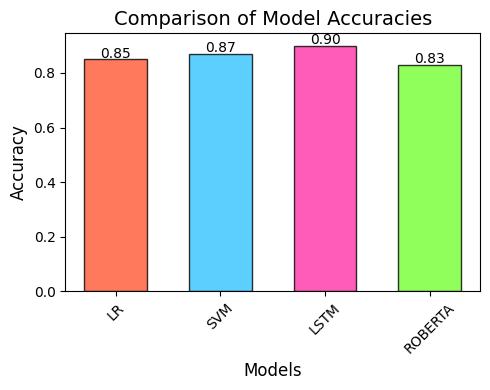

In [44]:
models = ['LR','SVM','LSTM','ROBERTA']
accuracies = [0.85, 0.87, 0.90, 0.83]
colors = ['#FF5733', '#33C3FF', '#FF33A8', '#75FF33']

plt.figure(figsize=(5, 4))
bar_positions = np.arange(len(models))
bar_width = 0.6

plt.bar(bar_positions, accuracies, width=bar_width, color= colors, edgecolor='black', alpha=0.8)

plt.xlabel('Models', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Comparison of Model Accuracies', fontsize=14)
plt.xticks(bar_positions, models, rotation=45, fontsize=10)

for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.005, f"{acc:.2f}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()